# Calculating Core AI scores, Marketing and Operational Scores

In [ ]:
import os
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.stem import WordNetLemmatizer
from tqdm import tqdm
import nltk

# Download NLTK resources
nltk.download('punkt', quiet=True)
nltk.download('wordnet', quiet=True)

# Initialize lemmatizer and embedding model
lemmatizer = WordNetLemmatizer()
embedding_model = SentenceTransformer("all-MiniLM-L6-v2")

# Folder path
folder_path = r"10k_html_sample"

# Reduced keyword lists with domain-specific terms only
core_ai_words = [
    "Pattern recognition", "Robotic process automation", "Predictive analytics", "Data pipelines", "MathWorks",
    "Speech recognition", "Robotic", "Cognitive framework", "Python", "Databricks",
    "OCR", "Robot", "Cognitive services", "TensorFlow", "H20.ai",
    "Handwriting recognition", "Artificial Intelligence", "Machine learning model", "Google cloud platform", "Datarobot",
    "Facial recognition", "Deep learning", "Machine learning framework", "Tensor", "Amazon Machine Learning",
    "Natural Language Processing", "Neural network", "Model training", "Tensor Processing Unit", "Google Cloud Machine Learning",
    "Natural Language Understanding", "Artificial neural network", "Customer segmentation", "TPU", "IBM Watson",
    "Intent classification", "Convolutional neural network", "Personalization engines", "Cuda", "Microsoft Azure Machine Learning",
    "Slot filling", "Recurrent neural network", "Inferencing", "Dialogflow", "Azure cognitive toolkit",
    "Entity recognition", "Generative adversarial network", "Embedding", "Word2Vec", "Apache SystemML",
    "Semantic translation", "Feedforward network", "Algorithm", "Doc2Vec", "Apache Spark MLlib",
    "Machine translation", "Machine learning", "Automation", "GloVe", "Apache Mahout",
    "Chatbot", "Supervised machine learning", "Data science", "Universal Sentence Encoding", "Caffe",
    "Autonomous agent", "Unsupervised machine learning", "Data acquisition", "Embeddings from language models", "OpenNN",
    "Language identification", "Supervised learning", "Data processing", "Neural network language model", "Torch",
    "Named entity extraction", "Unsupervised learning", "Modelling", "Latent semantic analysis", "Deeplearning4j",
    "Named entity recognition", "Reinforcement learning", "AI Operations", "Vector space models", "Veles",
    "Relationship extraction", "Model registry", "AIOps", "Deep averaging network", "Theano",
    "Terminology extraction", "Model manifestation", "Machine Learning Ops", "Prediction", "Scikit learning",
    "Semantic web", "Model servicing", "MLOps", "Clustering engine", "PyTorch",
    "Computer vision", "Model monitoring", "Machine Learning ontologies", "Topic modelling", "Keras",
    "Object recognition", "Model validation", "AI ethics", "RapidMiner", "Pandas",
    "Intelligent word recognition", "Transfer learning", "Machine Learning bias", "KNIME",
    "Intelligent image analysis", "Oneshot learning", "Machine bias", "Alteryx",
    "Image processing", "Pooling", "Training data", "SAS"
]

market_words = ["Recommendation", "Pricing", "Advertising", "Chatbot", 
                "Personalization", "Sentiment", "Targeting", "Churn"]

operational_words = ["Supply Chain", "Inventory", "Logistics", 
                    "Maintenance", "Procurement", "Manufacturing", 
                    "Fulfillment", "Workforce"]

# Lemmatize keywords
core_ai_words_lemmatized = [lemmatizer.lemmatize(word.lower()) for word in core_ai_words]
market_words_lemmatized = [lemmatizer.lemmatize(word.lower()) for word in market_words]
operational_words_lemmatized = [lemmatizer.lemmatize(word.lower()) for word in operational_words]

# Precompute embeddings
core_ai_embeddings = embedding_model.encode(core_ai_words)
market_embeddings = embedding_model.encode(market_words)
operational_embeddings = embedding_model.encode(operational_words)

# Compute center embeddings
core_market_center = np.mean(np.vstack([core_ai_embeddings, market_embeddings]), axis=0)
core_operational_center = np.mean(np.vstack([core_ai_embeddings, operational_embeddings]), axis=0)

def extract_text_from_html(file_path):
    with open(file_path, 'r', encoding='utf-8', errors='ignore') as f:
        soup = BeautifulSoup(f, features="lxml")  # Fixed: Use only features parameter
        return " ".join(elem.get_text(" ", strip=True) 
                       for elem in soup.find_all(['p', 'tr', 'td', 'div']) 
                       if elem.get_text(strip=True))

def calculate_word_based_scores(text, core_keywords, market_keywords, operational_keywords):
    tokens = [lemmatizer.lemmatize(token) for token in word_tokenize(text.lower())]
    total_words = max(len(tokens), 1)
    
    ai_count = sum(token in core_keywords for token in tokens)
    market_count = sum(token in market_keywords for token in tokens)
    operational_count = sum(token in operational_keywords for token in tokens)
    
    return (ai_count / total_words * 100,
            market_count / total_words * 100,
            operational_count / total_words * 100)

def compute_document_embedding(text, model, chunk_size=256):
    sentences = sent_tokenize(text)
    chunks = []
    current_chunk = []
    current_length = 0
    
    for sentence in sentences:
        token_count = len(word_tokenize(sentence))
        if current_length + token_count > chunk_size:
            if current_chunk:
                chunks.append(" ".join(current_chunk))
            current_chunk = [sentence]
            current_length = token_count
        else:
            current_chunk.append(sentence)
            current_length += token_count
    
    if current_chunk:
        chunks.append(" ".join(current_chunk))
    
    # Compute embeddings in batches for memory efficiency
    return np.mean(model.encode(chunks, batch_size=32, show_progress_bar=False), axis=0)

# Process files in batches
def process_files():
    html_files = [f for f in os.listdir(folder_path) if f.lower().endswith(".html")]
    results_method1 = []
    results_method2 = []
    
    for filename in tqdm(html_files, desc="Processing files"):
        file_path = os.path.join(folder_path, filename)
        text = extract_text_from_html(file_path)
        
        # Method 1: Word-based scores
        ai_score1, market_score1, ops_score1 = calculate_word_based_scores(
            text, core_ai_words_lemmatized, market_words_lemmatized, operational_words_lemmatized)
        
        # Method 2: Embedding-based scores
        doc_embedding = compute_document_embedding(text, embedding_model)
        
        ai_score2 = cosine_similarity([doc_embedding], [np.mean(core_ai_embeddings, axis=0)])[0][0] * 100
        market_score2 = cosine_similarity([doc_embedding], [np.mean(market_embeddings, axis=0)])[0][0] * 100
        ops_score2 = cosine_similarity([doc_embedding], [np.mean(operational_embeddings, axis=0)])[0][0] * 100
        
        # New center-based scores
        core_market_score = cosine_similarity([doc_embedding], [core_market_center])[0][0] * 100
        core_ops_score = cosine_similarity([doc_embedding], [core_operational_center])[0][0] * 100
        
        results_method1.append({
            "File Name": filename,
            "AI_Score (%)": ai_score1,
            "Marketing_AI_Score (%)": market_score1,
            "Operational_AI_Score (%)": ops_score1
        })
        
        results_method2.append({
            "File Name": filename,
            "AI_Score (%)": ai_score2,
            "Marketing_AI_Score (%)": market_score2,
            "Operational_AI_Score (%)": ops_score2,
            "Core_Market_Score (%)": core_market_score,
            "Core_Operational_Score (%)": core_ops_score
        })
    
    return pd.DataFrame(results_method1), pd.DataFrame(results_method2)

# Execute and combine results
df_method1, df_method2 = process_files()
df_combined = df_method1.merge(df_method2, on="File Name", suffixes=("_Method1", "_Method2"))



Processing files:   0%|          | 0/34 [00:00<?, ?it/s]C:\Users\kalagat23\AppData\Local\Temp\5\ipykernel_1528\3958336818.py:75: XMLParsedAsHTMLWarning: It looks like you're parsing an XML document using an HTML parser. If this really is an HTML document (maybe it's XHTML?), you can ignore or filter this warning. If it's XML, you should know that using an XML parser will be more reliable. To parse this document as XML, make sure you have the lxml package installed, and pass the keyword argument `features="xml"` into the BeautifulSoup constructor.
  soup = BeautifulSoup(f, features="lxml")  # Fixed: Use only features parameter
Processing files:   3%|▎         | 1/34 [00:06<03:48,  6.94s/it]C:\Users\kalagat23\AppData\Local\Temp\5\ipykernel_1528\3958336818.py:75: XMLParsedAsHTMLWarning: It looks like you're parsing an XML document using an HTML parser. If this really is an HTML document (maybe it's XHTML?), you can ignore or filter this warning. If it's XML, you should know that using an 

In [14]:
df_combined.head()

,File Name,AI_Score (%)_Method1,Marketing_AI_Score (%)_Method1,Operational_AI_Score (%)_Method1,AI_Score (%)_Method2,Marketing_AI_Score (%)_Method2,Operational_AI_Score (%)_Method2,Core_Market_Score (%),Core_Operational_Score (%)
0,2022-0001635881.html,0.000000,0.025919,0.145793,11.082213,16.931041,40.293670,11.763306,14.231560
1,2022-0001652044.html,0.001226,0.125083,0.036789,17.484029,24.058437,35.622025,18.360221,19.887838
2,2022-0001666700.html,0.000790,0.015006,0.071082,5.981927,11.223438,35.213709,6.505401,8.917487
3,2022-0001675149.html,0.007751,0.043182,0.057576,7.150079,13.377959,34.398386,7.772996,9.953004
4,2022-0001680379.html,0.000804,0.014201,0.008038,6.229059,11.771855,18.790305,6.780495,7.645197


# Classifying the AI words into two different classes. Marketing related and Operations related.

## Method 1 is word counts, Method 2 is embeddings

In [2]:
import os
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.stem import WordNetLemmatizer
from tqdm import tqdm
import nltk

nltk.download('punkt', quiet=True)
nltk.download('wordnet', quiet=True)

lemmatizer = WordNetLemmatizer()
embedding_model = SentenceTransformer("all-MiniLM-L6-v2")
folder_path = r"10k_html_sample"

# Full core_ai_words from literature
core_ai_words = [
    "Pattern recognition", "Robotic process automation", "Predictive analytics", "Data pipelines", "MathWorks",
    "Speech recognition", "Robotic", "Cognitive framework", "Python", "Databricks",
    "OCR", "Robot", "Cognitive services", "TensorFlow", "H20.ai",
    "Handwriting recognition", "Artificial Intelligence", "Machine learning model", "Google cloud platform", "Datarobot",
    "Facial recognition", "Deep learning", "Machine learning framework", "Tensor", "Amazon Machine Learning",
    "Natural Language Processing", "Neural network", "Model training", "Tensor Processing Unit", "Google Cloud Machine Learning",
    "Natural Language Understanding", "Artificial neural network", "Customer segmentation", "TPU", "IBM Watson",
    "Intent classification", "Convolutional neural network", "Personalization engines", "Cuda", "Microsoft Azure Machine Learning",
    "Slot filling", "Recurrent neural network", "Inferencing", "Dialogflow", "Azure cognitive toolkit",
    "Entity recognition", "Generative adversarial network", "Embedding", "Word2Vec", "Apache SystemML",
    "Semantic translation", "Feedforward network", "Algorithm", "Doc2Vec", "Apache Spark MLlib",
    "Machine translation", "Machine learning", "Automation", "GloVe", "Apache Mahout",
    "Chatbot", "Supervised machine learning", "Data science", "Universal Sentence Encoding", "Caffe",
    "Autonomous agent", "Unsupervised machine learning", "Data acquisition", "Embeddings from language models", "OpenNN",
    "Language identification", "Supervised learning", "Data processing", "Neural network language model", "Torch",
    "Named entity extraction", "Unsupervised learning", "Modelling", "Latent semantic analysis", "Deeplearning4j",
    "Named entity recognition", "Reinforcement learning", "AI Operations", "Vector space models", "Veles",
    "Relationship extraction", "Model registry", "AIOps", "Deep averaging network", "Theano",
    "Terminology extraction", "Model manifestation", "Machine Learning Ops", "Prediction", "Scikit learning",
    "Semantic web", "Model servicing", "MLOps", "Clustering engine", "PyTorch",
    "Computer vision", "Model monitoring", "Machine Learning ontologies", "Topic modelling", "Keras",
    "Object recognition", "Model validation", "AI ethics", "RapidMiner", "Pandas",
    "Intelligent word recognition", "Transfer learning", "Machine Learning bias", "KNIME",
    "Intelligent image analysis", "Oneshot learning", "Machine bias", "Alteryx",
    "Image processing", "Pooling", "Training data", "SAS"
]

# Classified subsets manually
marketing_ai_words = [
    "Pattern recognition", "Predictive analytics", "Speech recognition", "Cognitive framework", "OCR",
    "Handwriting recognition", "Facial recognition", "Natural Language Processing", "Natural Language Understanding",
    "Intent classification", "Slot filling", "Entity recognition", "Semantic translation", "Machine translation",
    "Chatbot", "Language identification", "Named entity extraction", "Named entity recognition",
    "Relationship extraction", "Terminology extraction", "Semantic web", "Customer segmentation",
    "Personalization engines", "Inferencing", "Embedding", "Word2Vec", "Doc2Vec", "GloVe",
    "Universal Sentence Encoding", "Embeddings from language models", "Neural network language model",
    "Latent semantic analysis", "Vector space models", "Deep averaging network", "Topic modelling",
    "Intelligent word recognition", "Dialogflow", "Google Cloud Platform"
]

operational_ai_words = [
    "Robotic process automation", "Data pipelines", "MathWorks", "Robotic", "Cognitive services",
    "Robot", "Artificial Intelligence", "Machine learning model", "Databricks", "H20.ai",
    "Deep learning", "Neural network", "Model training", "Tensor", "Amazon Machine Learning",
    "Artificial neural network", "Convolutional neural network", "Recurrent neural network",
    "Generative adversarial network", "Feedforward network", "Algorithm", "Apache SystemML",
    "Apache Spark MLlib", "Supervised machine learning", "Unsupervised machine learning", "Automation",
    "Autonomous agent", "Supervised learning", "Unsupervised learning", "Reinforcement learning",
    "Data acquisition", "Data processing", "Modelling", "AI Operations", "AIOps", "Machine Learning Ops",
    "MLOps", "Prediction", "Clustering engine", "Computer vision", "Object recognition",
    "Intelligent image analysis", "Image processing", "Pooling", "Training data", "TensorFlow",
    "Cuda", "Microsoft Azure Machine Learning", "Azure cognitive toolkit", "Apache Mahout", "Caffe",
    "OpenNN", "Torch", "Deeplearning4j", "Veles", "Theano", "PyTorch", "Keras", "Pandas",
    "RapidMiner", "KNIME", "Alteryx", "SAS"
]

# Lemmatize
core_ai_words_lemmatized = [lemmatizer.lemmatize(word.lower()) for word in core_ai_words]
marketing_ai_words_lemmatized = [lemmatizer.lemmatize(word.lower()) for word in marketing_ai_words]
operational_ai_words_lemmatized = [lemmatizer.lemmatize(word.lower()) for word in operational_ai_words]

# Precompute embeddings
core_ai_embeddings = embedding_model.encode(core_ai_words)
marketing_ai_embeddings = embedding_model.encode(marketing_ai_words)
operational_ai_embeddings = embedding_model.encode(operational_ai_words)

def extract_text_from_html(file_path):
    with open(file_path, 'r', encoding='utf-8', errors='ignore') as f:
        soup = BeautifulSoup(f, features="lxml")
        for tag in soup(['header', 'footer', 'nav', 'script', 'style']):
            tag.decompose()
        return " ".join(elem.get_text(" ", strip=True) 
                       for elem in soup.find_all(['p', 'tr', 'td', 'div']) 
                       if elem.get_text(strip=True))

def calculate_word_based_scores(text, core_keywords, marketing_keywords, operational_keywords):
    tokens = [lemmatizer.lemmatize(token) for token in word_tokenize(text.lower())]
    total_words = max(len(tokens), 1)
    
    ai_count = sum(token in core_keywords for token in tokens)
    marketing_count = sum(token in marketing_keywords for token in tokens)
    operational_count = sum(token in operational_keywords for token in tokens)
    total_specific = marketing_count + operational_count
    
    ai_score = ai_count / total_words * 100
    if total_specific > 0:
        marketing_score = (marketing_count / total_specific) * (total_specific / total_words * 100)
        operational_score = (operational_count / total_specific) * (total_specific / total_words * 100)
    else:
        marketing_score = operational_score = 0
    
    return ai_score, marketing_score, operational_score

def compute_document_embedding(text, model, chunk_size=256):
    sentences = sent_tokenize(text)
    chunks = []
    current_chunk = []
    current_length = 0
    for sentence in sentences:
        token_count = len(word_tokenize(sentence))
        if current_length + token_count > chunk_size:
            if current_chunk:
                chunks.append(" ".join(current_chunk))
            current_chunk = [sentence]
            current_length = token_count
        else:
            current_chunk.append(sentence)
            current_length += token_count
    if current_chunk:
        chunks.append(" ".join(current_chunk))
    return np.mean(model.encode(chunks, batch_size=32, show_progress_bar=False), axis=0)

def process_files():
    html_files = [f for f in os.listdir(folder_path) if f.lower().endswith(".html")]
    results_method1 = []
    results_method2 = []
    
    for filename in tqdm(html_files, desc="Processing files"):
        file_path = os.path.join(folder_path, filename)
        text = extract_text_from_html(file_path)
        
        # Method 1: Word-based scores
        ai_score1, marketing_score1, operational_score1 = calculate_word_based_scores(
            text, core_ai_words_lemmatized, marketing_ai_words_lemmatized, operational_ai_words_lemmatized)
        
        # Method 2: Embedding-based scores
        doc_embedding = compute_document_embedding(text, embedding_model)
        ai_score2 = cosine_similarity([doc_embedding], [np.mean(core_ai_embeddings, axis=0)])[0][0] * 100
        marketing_score2 = cosine_similarity([doc_embedding], [np.mean(marketing_ai_embeddings, axis=0)])[0][0] * 100
        operational_score2 = cosine_similarity([doc_embedding], [np.mean(operational_ai_embeddings, axis=0)])[0][0] * 100
        
        results_method1.append({
            "File Name": filename,
            "AI_Score (%)": ai_score1,
            "Marketing_AI_Score (%)": marketing_score1,
            "Operational_AI_Score (%)": operational_score1
        })
        
        results_method2.append({
            "File Name": filename,
            "AI_Score (%)": ai_score2,
            "Marketing_AI_Score (%)": marketing_score2,
            "Operational_AI_Score (%)": operational_score2
        })
    
    return pd.DataFrame(results_method1), pd.DataFrame(results_method2)

df_method1, df_method2 = process_files()
df_combined = df_method1.merge(df_method2, on="File Name", suffixes=("_Method1", "_Method2"))

Processing files:   0%|          | 0/34 [00:00<?, ?it/s]C:\Users\kalagat23\AppData\Local\Temp\3\ipykernel_30116\333709789.py:89: XMLParsedAsHTMLWarning: It looks like you're parsing an XML document using an HTML parser. If this really is an HTML document (maybe it's XHTML?), you can ignore or filter this warning. If it's XML, you should know that using an XML parser will be more reliable. To parse this document as XML, make sure you have the lxml package installed, and pass the keyword argument `features="xml"` into the BeautifulSoup constructor.
  soup = BeautifulSoup(f, features="lxml")
Processing files:   3%|▎         | 1/34 [00:08<04:46,  8.69s/it]C:\Users\kalagat23\AppData\Local\Temp\3\ipykernel_30116\333709789.py:89: XMLParsedAsHTMLWarning: It looks like you're parsing an XML document using an HTML parser. If this really is an HTML document (maybe it's XHTML?), you can ignore or filter this warning. If it's XML, you should know that using an XML parser will be more reliable. To p

In [4]:
df_combined.head()

,File Name,AI_Score (%)_Method1,Marketing_AI_Score (%)_Method1,Operational_AI_Score (%)_Method1,AI_Score (%)_Method2,Marketing_AI_Score (%)_Method2,Operational_AI_Score (%)_Method2
0,2022-0001635881.html,0.000000,0.0,0.000000,11.082213,12.598167,8.813243
1,2022-0001652044.html,0.001226,0.0,0.001226,17.484029,20.856874,12.625991
2,2022-0001666700.html,0.000790,0.0,0.000790,5.981927,7.478993,3.926814
3,2022-0001675149.html,0.007751,0.0,0.007751,7.150079,5.709281,7.427061
4,2022-0001680379.html,0.000804,0.0,0.000804,6.229059,8.389450,3.863275


In [5]:
print(df_combined[['AI_Score (%)_Method1', 'Marketing_AI_Score (%)_Method1', 
                  'Operational_AI_Score (%)_Method1']].corr())

                                  AI_Score (%)_Method1  \
AI_Score (%)_Method1                          1.000000   
Marketing_AI_Score (%)_Method1                0.093707   
Operational_AI_Score (%)_Method1              0.999231   

                                  Marketing_AI_Score (%)_Method1  \
AI_Score (%)_Method1                                    0.093707   
Marketing_AI_Score (%)_Method1                          1.000000   
Operational_AI_Score (%)_Method1                        0.054604   

                                  Operational_AI_Score (%)_Method1  
AI_Score (%)_Method1                                      0.999231  
Marketing_AI_Score (%)_Method1                            0.054604  
Operational_AI_Score (%)_Method1                          1.000000  


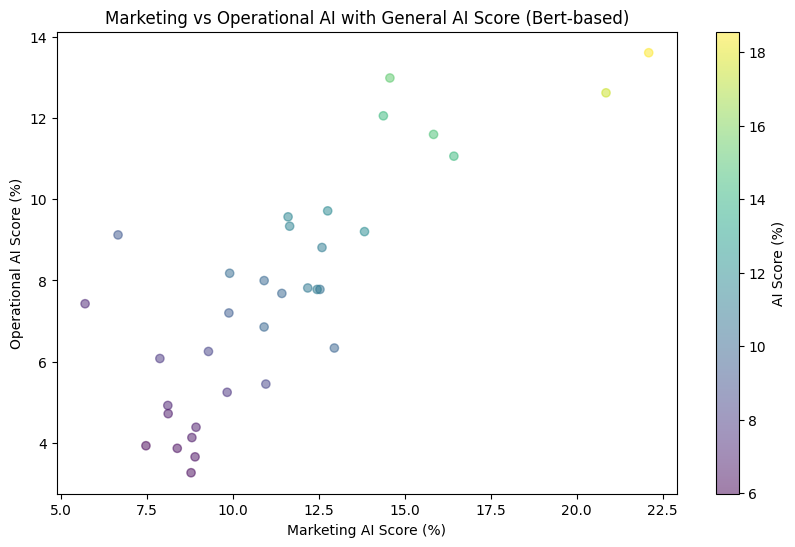

In [9]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
scatter = plt.scatter(df_combined['Marketing_AI_Score (%)_Method2'], 
                      df_combined['Operational_AI_Score (%)_Method2'], 
                      c=df_combined['AI_Score (%)_Method2'], cmap='viridis', alpha=0.5)
plt.xlabel('Marketing AI Score (%)')
plt.ylabel('Operational AI Score (%)')
plt.title('Marketing vs Operational AI with General AI Score (Bert-based)')
plt.colorbar(scatter, label='AI Score (%)')
plt.show()

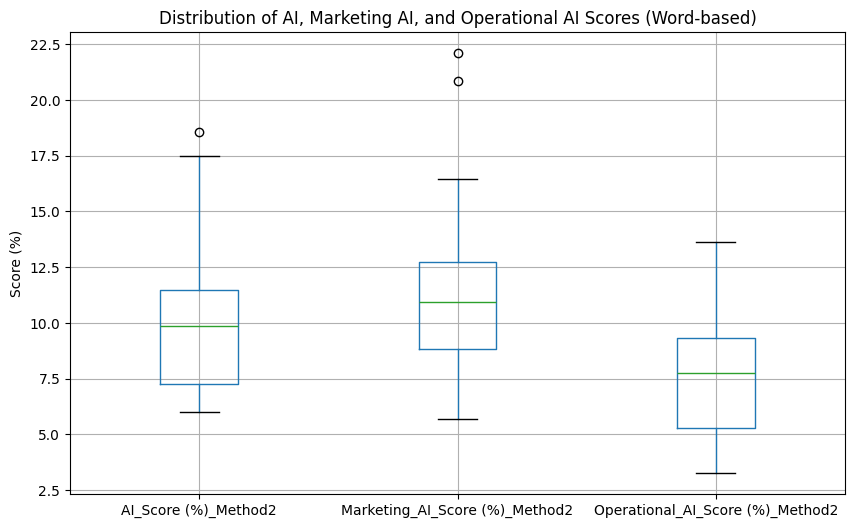

In [8]:
plt.figure(figsize=(10, 6))
df_combined[['AI_Score (%)_Method2', 'Marketing_AI_Score (%)_Method2', 
             'Operational_AI_Score (%)_Method2']].boxplot()
plt.title('Distribution of AI, Marketing AI, and Operational AI Scores (Word-based)')
plt.ylabel('Score (%)')
plt.show()

C:\Users\kalagat23\AppData\Local\Temp\3\ipykernel_30116\333709789.py:89: XMLParsedAsHTMLWarning: It looks like you're parsing an XML document using an HTML parser. If this really is an HTML document (maybe it's XHTML?), you can ignore or filter this warning. If it's XML, you should know that using an XML parser will be more reliable. To parse this document as XML, make sure you have the lxml package installed, and pass the keyword argument `features="xml"` into the BeautifulSoup constructor.
  soup = BeautifulSoup(f, features="lxml")


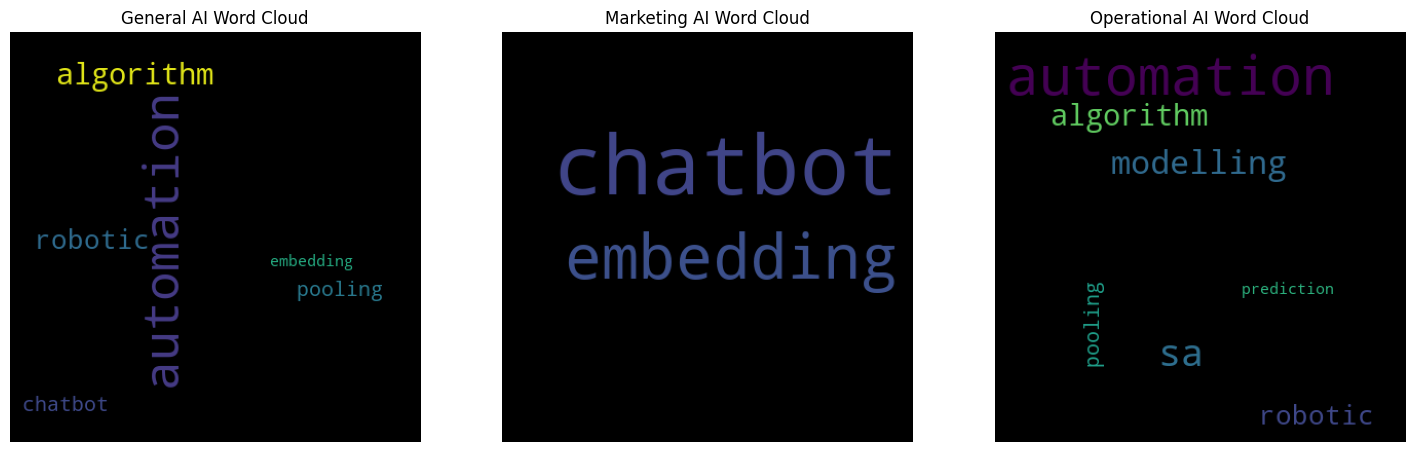

In [11]:
from wordcloud import WordCloud
from collections import Counter

high_ai_files = df_combined.nlargest(20, 'AI_Score (%)_Method2')['File Name']
high_marketing_files = df_combined.nlargest(20, 'Marketing_AI_Score (%)_Method2')['File Name']
high_operational_files = df_combined.nlargest(20, 'Operational_AI_Score (%)_Method2')['File Name']

ai_text = " ".join(extract_text_from_html(os.path.join(folder_path, f)) for f in high_ai_files)
marketing_text = " ".join(extract_text_from_html(os.path.join(folder_path, f)) for f in high_marketing_files)
operational_text = " ".join(extract_text_from_html(os.path.join(folder_path, f)) for f in high_operational_files)

ai_freq = Counter(t for t in word_tokenize(ai_text.lower()) if t in core_ai_words_lemmatized)
marketing_freq = Counter(t for t in word_tokenize(marketing_text.lower()) if t in marketing_ai_words_lemmatized)
operational_freq = Counter(t for t in word_tokenize(operational_text.lower()) if t in operational_ai_words_lemmatized)

plt.figure(figsize=(18, 6))
plt.subplot(1, 3, 1)
plt.imshow(WordCloud(width=400, height=400).generate_from_frequencies(ai_freq))
plt.axis('off')
plt.title('General AI Word Cloud')
plt.subplot(1, 3, 2)
plt.imshow(WordCloud(width=400, height=400).generate_from_frequencies(marketing_freq))
plt.axis('off')
plt.title('Marketing AI Word Cloud')
plt.subplot(1, 3, 3)
plt.imshow(WordCloud(width=400, height=400).generate_from_frequencies(operational_freq))
plt.axis('off')
plt.title('Operational AI Word Cloud')
plt.show()

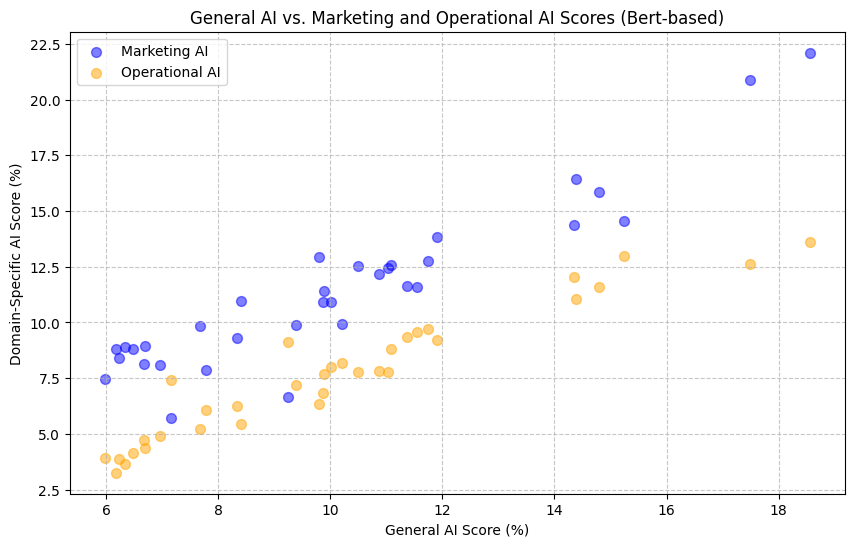

In [12]:
import matplotlib.pyplot as plt

# Scatter plot: AI Score on x-axis, Marketing and Operational AI Scores on y-axis with different colors
plt.figure(figsize=(10, 6))

# Plot Marketing AI Scores in blue
plt.scatter(df_combined['AI_Score (%)_Method2'], 
            df_combined['Marketing_AI_Score (%)_Method2'], 
            color='blue', label='Marketing AI', alpha=0.5, s=50)

# Plot Operational AI Scores in orange
plt.scatter(df_combined['AI_Score (%)_Method2'], 
            df_combined['Operational_AI_Score (%)_Method2'], 
            color='orange', label='Operational AI', alpha=0.5, s=50)

plt.xlabel('General AI Score (%)')
plt.ylabel('Domain-Specific AI Score (%)')
plt.title('General AI vs. Marketing and Operational AI Scores (Bert-based)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

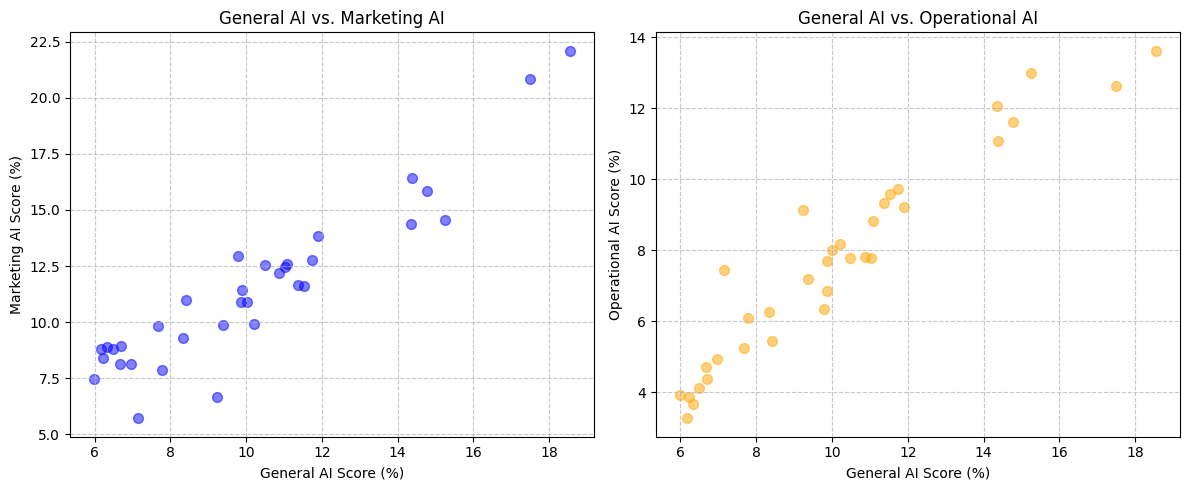

In [13]:
plt.figure(figsize=(12, 5))

# Subplot 1: AI vs. Marketing AI
plt.subplot(1, 2, 1)
plt.scatter(df_combined['AI_Score (%)_Method2'], 
            df_combined['Marketing_AI_Score (%)_Method2'], 
            color='blue', alpha=0.5, s=50)
plt.xlabel('General AI Score (%)')
plt.ylabel('Marketing AI Score (%)')
plt.title('General AI vs. Marketing AI')
plt.grid(True, linestyle='--', alpha=0.7)

# Subplot 2: AI vs. Operational AI
plt.subplot(1, 2, 2)
plt.scatter(df_combined['AI_Score (%)_Method2'], 
            df_combined['Operational_AI_Score (%)_Method2'], 
            color='orange', alpha=0.5, s=50)
plt.xlabel('General AI Score (%)')
plt.ylabel('Operational AI Score (%)')
plt.title('General AI vs. Operational AI')
plt.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

In [14]:
df_combined.to_csv('10k_with_ai_marketing_operation_score.csv')